# Bootstrap Resampling for Precipitation Analysis

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import xesmf as xe
import nc_time_axis
import cftime 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from scipy import stats

In [2]:
# Import dask
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory='10GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='/glade/scratch/kdagon/dask-local', # Use your dask-local directory
    resource_spec='select=1:ncpus=1:mem=10GB', # Specify resources
    project='P06010014', # Input your project ID here
    walltime='04:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up -- how to determine this number?
# Here asking for 10 or 20 nodes (10 or 20 dask workers)
cluster.scale(20)

# Adaptive scaling option!
#cluster.adapt(minimum=1, maximum=100, wait_count=60)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34973 instead
  warnings.warn(


In [3]:
client

Connection method: Cluster object,Cluster type: PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/34973/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/34973/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.54:41990,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/34973/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Read and process precipitation given input file

In [5]:
def process_PRECT(path, file):
    PRECT_1deg = xr.open_dataarray(path+file, chunks={'time':600, 'lat':10, 'lon':20})
    
    # subset for a 15-year climatology (if applicable)
    if PRECT_1deg.shape[0] > 43800:
        PRECT_1deg = PRECT_1deg[:43800]
    
    # subset for CONUS only
    PRECT_CONUS = PRECT_1deg.sel(lat=slice(26,50), lon=slice(-125,-68))
    
    # select seasonal values
    PRECT_DJF = PRECT_CONUS.sel(time=PRECT_CONUS.time.dt.season=="DJF")
    PRECT_MAM = PRECT_CONUS.sel(time=PRECT_CONUS.time.dt.season=="MAM")
    PRECT_JJA = PRECT_CONUS.sel(time=PRECT_CONUS.time.dt.season=="JJA")
    PRECT_SON = PRECT_CONUS.sel(time=PRECT_CONUS.time.dt.season=="SON")
    
    return(PRECT_DJF, PRECT_MAM, PRECT_JJA, PRECT_SON)

In [6]:
postprocessing_filepath = '/glade/campaign/cgd/ccr/kdagon/dlfront/postprocessing/'
PRECT_file = 'PRECT_3hravg_NA_hist_rcp26_1deg_bil.nc' # bilinear interpolation, units are m/s
#PRECT_file = 'PRECT_3hravg_NA_hist_rcp26_1deg_cons.nc' # conservative regridding
PRECT_DJF, PRECT_MAM, PRECT_JJA, PRECT_SON = process_PRECT(postprocessing_filepath, PRECT_file)

PRECT_file_rcp = 'PRECT_3hravg_NA_rcp85_1deg_bil.nc'
PRECT_DJF_rcp, PRECT_MAM_rcp, PRECT_JJA_rcp, PRECT_SON_rcp = process_PRECT(postprocessing_filepath, PRECT_file_rcp)

## Bootstrap resampling

### Create components for bootstrapping

In [7]:
def process_timeseries(P1, P2):

    # precipitation for each simulation
    P_concat = xr.concat([P1, P2], dim='time')
    
    return(P_concat)

In [8]:
# seasonal timeseries
PRECT_DJF_concat = process_timeseries(PRECT_DJF, PRECT_DJF_rcp)
PRECT_MAM_concat = process_timeseries(PRECT_MAM, PRECT_MAM_rcp)
PRECT_JJA_concat = process_timeseries(PRECT_JJA, PRECT_JJA_rcp)
PRECT_SON_concat = process_timeseries(PRECT_SON, PRECT_SON_rcp)

In [9]:
%%time
# compute values to load into memory
PRECT_DJF_concat_compute = PRECT_DJF_concat.compute()

CPU times: user 3.75 s, sys: 611 ms, total: 4.36 s
Wall time: 16.5 s


In [10]:
%%time
# compute the rest of the seasons
PRECT_MAM_concat_compute = PRECT_MAM_concat.compute()
PRECT_JJA_concat_compute = PRECT_JJA_concat.compute()
PRECT_SON_concat_compute = PRECT_SON_concat.compute()

CPU times: user 8.7 s, sys: 1.73 s, total: 10.4 s
Wall time: 25.1 s


In [11]:
# calculate number of timesteps for each season
totalsize_DJF = PRECT_DJF_concat.time.size
totalsize_MAM = PRECT_MAM_concat.time.size
totalsize_JJA = PRECT_JJA_concat.time.size
totalsize_SON = PRECT_SON_concat.time.size

### DJF

In [21]:
%%time
# NOTE: load the concatenated arrays into memory first

#nsamps = 10
nsamps = 1000

# initialize a difference array
diffs_DJF = xr.zeros_like(PRECT_DJF_concat_compute[:nsamps,:,:]).reset_index('time', drop='True').rename({'time': 'sample'})

for ind in range(nsamps):
    
    # sample 1 - set the random seed for reproducibility
    np.random.seed(ind+1)
    # create the random indices based on totalsize
    rand_index = np.random.choice(totalsize_DJF, size=int(totalsize_DJF/2), replace=True)
    # randomly sample the concatenated precip across hist/rcp
    boot_1 = PRECT_DJF_concat_compute.isel(time=rand_index).mean(dim='time') 
    
    # sample 2 - different random seed
    np.random.seed(ind+10)
    rand_index = np.random.choice(totalsize_DJF, size=int(totalsize_DJF/2), replace=True)
    boot_2 = PRECT_DJF_concat_compute.isel(time=rand_index).mean(dim='time')
    
    Punits = 60*60*24*1000 # convert m/s to mm/day
    
    # final bootstrap sample is the difference between means of each sample
    diffs_DJF[ind,...] = (boot_1 - boot_2)*Punits
    
    # test first iteration of loop
    #break

CPU times: user 3min 32s, sys: 3min 50s, total: 7min 22s
Wall time: 8min 20s


In [22]:
diffs_DJF.shape

(1000, 25, 58)

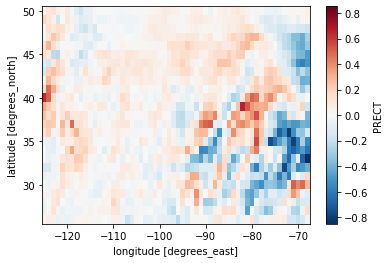

In [23]:
# distribution of values at first sample across space
diffs_DJF.isel(sample=0).plot();

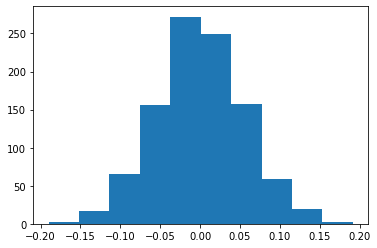

In [24]:
# distribution of values at first spatial point
plt.hist(diffs_DJF[:,0,0]);

In [25]:
lev_1 = 0.025
lev_2 = 0.975

DJF_quantiles = diffs_DJF.quantile([lev_1,lev_2], dim='sample')

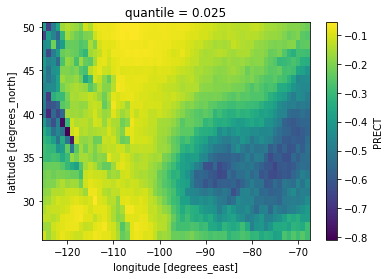

In [26]:
DJF_quantiles.sel(quantile=lev_1).plot();

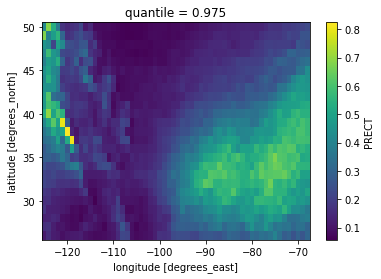

In [27]:
DJF_quantiles.sel(quantile=lev_2).plot();

### MAM

In [28]:
%%time
# NOTE: load the concatenated arrays into memory first

#nsamps = 10
nsamps = 1000

# initialize a difference array
diffs_MAM = xr.zeros_like(PRECT_MAM_concat_compute[:nsamps,:,:]).reset_index('time', drop='True').rename({'time': 'sample'})

for ind in range(nsamps):
    
    # sample 1 - set the random seed for reproducibility
    np.random.seed(ind+1)
    # create the random indices based on totalsize
    rand_index = np.random.choice(totalsize_MAM, size=int(totalsize_MAM/2), replace=True)
    # randomly sample the concatenated precip across hist/rcp
    boot_1 = PRECT_MAM_concat_compute.isel(time=rand_index).mean(dim='time') 
    
    # sample 2 - different random seed
    np.random.seed(ind+10)
    rand_index = np.random.choice(totalsize_MAM, size=int(totalsize_MAM/2), replace=True)
    boot_2 = PRECT_MAM_concat_compute.isel(time=rand_index).mean(dim='time')
    
    Punits = 60*60*24*1000 # convert m/s to mm/day
    
    # final bootstrap sample is the difference between means of each sample
    diffs_MAM[ind,...] = (boot_1 - boot_2)*Punits
    
    # test first iteration of loop
    #break

CPU times: user 3min 33s, sys: 3min 40s, total: 7min 13s
Wall time: 8min 28s


In [29]:
MAM_quantiles = diffs_MAM.quantile([lev_1,lev_2], dim='sample')

### JJA

In [30]:
%%time
# NOTE: load the concatenated arrays into memory first

#nsamps = 10
nsamps = 1000

# initialize a difference array
diffs_JJA = xr.zeros_like(PRECT_JJA_concat_compute[:nsamps,:,:]).reset_index('time', drop='True').rename({'time': 'sample'})

for ind in range(nsamps):
    
    # sample 1 - set the random seed for reproducibility
    np.random.seed(ind+1)
    # create the random indices based on totalsize
    rand_index = np.random.choice(totalsize_JJA, size=int(totalsize_JJA/2), replace=True)
    # randomly sample the concatenated precip across hist/rcp
    boot_1 = PRECT_JJA_concat_compute.isel(time=rand_index).mean(dim='time') 
    
    # sample 2 - different random seed
    np.random.seed(ind+10)
    rand_index = np.random.choice(totalsize_JJA, size=int(totalsize_JJA/2), replace=True)
    boot_2 = PRECT_JJA_concat_compute.isel(time=rand_index).mean(dim='time')
    
    Punits = 60*60*24*1000 # convert m/s to mm/day
    
    # final bootstrap sample is the difference between means of each sample
    diffs_JJA[ind,...] = (boot_1 - boot_2)*Punits
    
    # test first iteration of loop
    #break

CPU times: user 3min 48s, sys: 3min 39s, total: 7min 28s
Wall time: 11min 55s


In [31]:
JJA_quantiles = diffs_JJA.quantile([lev_1,lev_2], dim='sample')

### SON

In [32]:
%%time
# NOTE: load the concatenated arrays into memory first

#nsamps = 10
nsamps = 1000

# initialize a difference array
diffs_SON = xr.zeros_like(PRECT_SON_concat_compute[:nsamps,:,:]).reset_index('time', drop='True').rename({'time': 'sample'})

for ind in range(nsamps):
    
    # sample 1 - set the random seed for reproducibility
    np.random.seed(ind+1)
    # create the random indices based on totalsize
    rand_index = np.random.choice(totalsize_SON, size=int(totalsize_SON/2), replace=True)
    # randomly sample the concatenated precip across hist/rcp
    boot_1 = PRECT_SON_concat_compute.isel(time=rand_index).mean(dim='time') 
    
    # sample 2 - different random seed
    np.random.seed(ind+10)
    rand_index = np.random.choice(totalsize_SON, size=int(totalsize_SON/2), replace=True)
    boot_2 = PRECT_SON_concat_compute.isel(time=rand_index).mean(dim='time')
    
    Punits = 60*60*24*1000 # convert m/s to mm/day
    
    # final bootstrap sample is the difference between means of each sample
    diffs_SON[ind,...] = (boot_1 - boot_2)*Punits
    
    # test first iteration of loop
    #break

CPU times: user 3min 33s, sys: 3min 31s, total: 7min 5s
Wall time: 8min 53s


In [33]:
SON_quantiles = diffs_SON.quantile([lev_1,lev_2], dim='sample')

## Save out quantile values for plotting in other notebooks

### Concatenate across season for easier plotting

In [34]:
seasonal_quantiles = xr.concat([DJF_quantiles, MAM_quantiles, JJA_quantiles, SON_quantiles], dim='season')
seasonal_quantiles.coords["season"] = ['DJF','MAM','JJA','SON']
seasonal_quantiles

<xarray.DataArray 'PRECT' (season: 4, quantile: 2, lat: 25, lon: 58)>
array([[[[-0.11062664, -0.16674568, -0.12694022, ..., -0.29291342,
          -0.25344759, -0.2903318 ],
         [-0.16787476, -0.1661596 , -0.11450889, ..., -0.32944685,
          -0.34939137, -0.29197385],
         [-0.12577099, -0.13160655, -0.14066794, ..., -0.33192418,
          -0.39039065, -0.3859332 ],
         ...,
         [-0.45049513, -0.42799539, -0.21909966, ..., -0.26311556,
          -0.24354035, -0.24031486],
         [-0.65275376, -0.39325039, -0.46834517, ..., -0.20281756,
          -0.24834191, -0.25719852],
         [-0.39881057, -0.67396442, -0.4875899 , ..., -0.19609389,
          -0.20734018, -0.22529981]],

        [[ 0.1098861 ,  0.15422407,  0.11946358, ...,  0.29637042,
           0.26173185,  0.30704355],
         [ 0.15844385,  0.16649483,  0.12039288, ...,  0.33784837,
           0.34173262,  0.29985426],
         [ 0.12598811,  0.13080966,  0.14436043, ...,  0.34210965,
           0.3711856 ,  0.38291594],
...
         [-0.45188961, -0.43678776, -0.19727181, ..., -0.36428778,
          -0.338897  , -0.36665215],
         [-0.59692002, -0.42618104, -0.49197323, ..., -0.30664567,
          -0.38133943, -0.3449632 ],
         [-0.46605131, -0.69368594, -0.52344672, ..., -0.30142267,
          -0.32388119, -0.33451473]],

        [[ 0.09225332,  0.11967157,  0.13174602, ...,  0.46801453,
           0.39110347,  0.29177604],
         [ 0.08983224,  0.07687977,  0.07176131, ...,  0.36342764,
           0.302491  ,  0.27610517],
         [ 0.09471374,  0.08428376,  0.07066402, ...,  0.42900842,
           0.35309949,  0.2813387 ],
         ...,
         [ 0.44559262,  0.43605256,  0.21272246, ...,  0.34616764,
           0.34126386,  0.3267011 ],
         [ 0.61993376,  0.39631797,  0.50178688, ...,  0.3039812 ,
           0.34261245,  0.31095698],
         [ 0.49432804,  0.72524372,  0.55633393, ...,  0.28867197,
           0.30919214,  0.32020867]]]])
Coordinates:
  * lon       (lon) float64 -125.0 -124.0 -123.0 -122.0 ... -70.0 -69.0 -68.0
  * lat       (lat) float64 26.0 27.0 28.0 29.0 30.0 ... 47.0 48.0 49.0 50.0
  * quantile  (quantile) float64 0.025 0.975
  * season    (season) <U3 'DJF' 'MAM' 'JJA' 'SON'

In [35]:
seasonal_quantiles.to_netcdf(postprocessing_filepath+'PRECT_boot_diffs_byseason.nc', mode='w', format='NETCDF4')